# Laboratório 6
Material desenvolvido por Henrique Margotte e Aurora Pozo para a disciplina de Aprendizado de Máquina, para o curso de Informática Biomédica da UFPR, semestre 2025/2. Códigos baseados em exemplos da biblioteca scikit-learn e nos notebooks Python do livro "Inteligência Artificial: Uma Abordagem de Aprendizado de Máquina", 2ª edição.

# Exemplo 1: AutoEncoders
No laboratório de hoje, veremos uma técnica diferente de Aprendizado de Máquina, os AutoCodificadores, ou AutoEncoders (AE). Os AEs são considerados como um método de aprendizado auto-supervisionado (ou _self supervised learning_), em que o próprio modelo define as "classes", para funcionar de modo semelhante ao aprendizado supervisionado. O AE funciona de modo que a entrada e saída esperada do modelo são iguais, ou seja, o modelo vai apenas aprender como copiar a entrada para a saída! Dessa forma, não precisamos rotular os dados, mas temos o objetivo de cada entrada bem definido! Os Grandes Modelos de Linguagem (LLMs) também se encaixam nesse método de aprendizado, sendo treinados com as palavras anteriores tentando prever a próxima palavra dentro de um mesmo texto.

Mas... isso não seria apenas copiar a entrada para a saída? Só fazendo os neurônios replicarem a entrada sem a alterarem? Sim, _seria_. A diferença é que os AEs possuem uma estrutura própria, dividida em duas partes:
- Codificador (*Encoder*): Conjunto de camadas que recebe os dados de entrada e processá-os, os "codificando" para um vetor de tamanho menor do que a entrada, chamado de Vetor Latente (*Feature Vector*), que é gerado como saída do Codificador.
- Decodificador (*Decoder*): Conjunto de camadas que recebe o Vetor Latente como entrada e o transforma na saída esperada.

E para que serve isso?! Ao conseguirmos fazer a codificação e decodificação de dados, conseguimos definir o vetor latente como uma representação dos dados em uma menor dimensão, ou seja, os AEs podem servir como técnicas de Redução de Dimensionalidade!

Vamos ver um exemplo de como treinar um AE e extrair o Vetor Latente. Como o scikit-learn não possui AE definidos, iremos utilizar o Keras, que também nos permite dividir o codificador e decodificador! Para os dados, utilizaremos a base `digits`.

A base `digits` do scikit-learn é formada por imagens de dígitos de 0 a 9. Cada imagem é um array de 64 valores, representando uma figura de 8x8 pixels, com cada valor variando de 0 (preto) a 16 (branco).

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

np.int64(0)

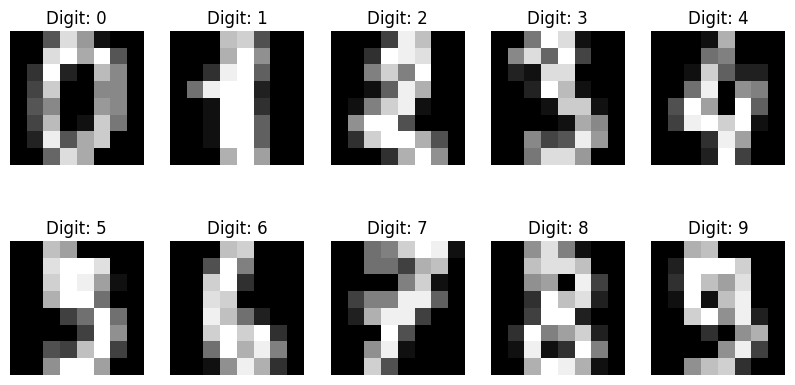

In [12]:
# Importando as bibliotecas
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models

# Carregando a base de dados
digits = load_digits()
X = digits.data
y = digits.target

display(X[0].reshape(8, 8), y[0])

# Visualizando alguns dígitos
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(X[i].reshape(8, 8), cmap='gray')
    ax.set_title(f'Digit: {y[i]}')
    ax.axis('off')
plt.show()

Sabendo o tamanho dos elementos da base, podemos definir o nosso AE, que terá uma entrada e uma saída de 64 valores, e definiremos um vetor latente de tamanho 32. Ainda é possível incluir outras camadas antes e depois do vetor latente, mas é comum que seja uma rede simétrica!

Text(0.5, 1.0, 'Autoencoder Loss Curve')

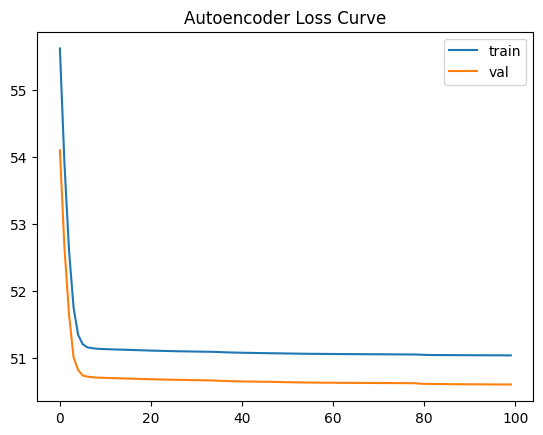

In [24]:
# Dividindo em treino e teste
X_train, X_test = train_test_split(X, test_size=0.2, random_state=0)
y_train, y_test = train_test_split(y, test_size=0.2, random_state=0)

input_dim = X.shape[1]
encoding_dim = 32

input_layer = layers.Input(shape=(input_dim,))
encoded = layers.Dense(encoding_dim, activation='relu')(input_layer)
decoded = layers.Dense(input_dim, activation='sigmoid')(encoded)

autoencoder = models.Model(input_layer, decoded)
encoder = models.Model(input_layer, encoded)

autoencoder.compile(optimizer='adam', loss='mse')
history = autoencoder.fit(X_train, X_train, 
                          epochs=100, batch_size=128,
                          validation_data=(X_test, X_test), verbose=0)

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend(); plt.title("Autoencoder Loss Curve")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


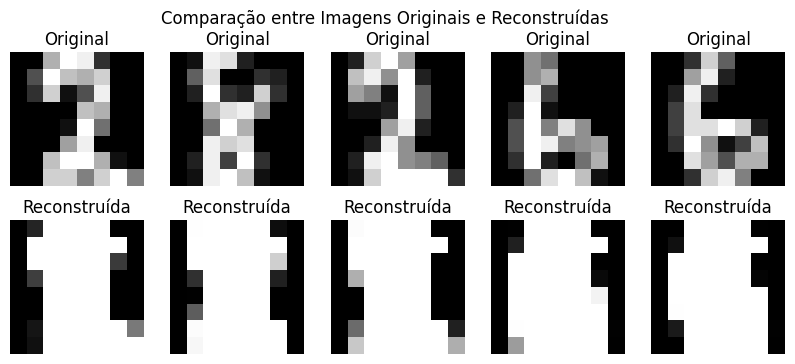

In [25]:
# Comparando imagens originais e reconstruídas
n = 5  # Número de imagens para mostrar
plt.figure(figsize=(10, 4))
for i in range(n):
    # Imagem original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(8,8), cmap='gray')
    plt.title("Original")
    plt.axis("off")

    # Imagem reconstruída
    ax = plt.subplot(2, n, i + 1 + n)
    reconstructed = autoencoder.predict(X_test[i].reshape(1, -1))
    plt.imshow(reconstructed.reshape(8,8), cmap='gray')
    plt.title("Reconstruída")
    plt.axis("off")
plt.suptitle("Comparação entre Imagens Originais e Reconstruídas")
plt.show()

Conseguimos ver que a reconstrução não foi perfeita, mas que consegue extrair algumas características importantes dos dados, que poderiam ser utilizadas em um classificador...

# Exercício!

SUA VEZ!

Vamos ver se um AE seria interessante para a Redução de Dimensionalidade para a base digits!

- Instale e extraia a base `digits` do scikit-learn
- Treine um AutoEncoder com essa base
  - Varie tamanhos de camadas, quantidade de camadas, tamanho do vetor latente, função de loss...
  - Verifique a curva de loss para entender como o modelo está treinando
- Extraia o Vetor Latente desse AE e aplique em um modelo de Classificação de sua escolha, que identifique qual o dígito da imagem
- Compare o desempenho do classificador das seguintes formas:
  - Usando a imagem completa de entrada
  - Usando PCA para redução de dimensionalidade
  - Usando AE para redução de dimensionalidade
- Tente encontrar o menor tamanho de Vetor Latente que obtenha os melhores resultados!

DESAFIO! (Opcional)

Uma outra aplicação de AE é para um problema chamado de Detecção de Anomalia. Quando temos dados desbalanceados e queremos identificar os outliers, ou seja, as anomalias das classes menores, podemos treinar um AE com a classe majoritária e verificar qual o erro da reconstrução. Se o modelo errar muito em um certo elemento, é possível que seja uma anomalia!

Estude e escolha uma base desbalanceada e aplique um AE para detectar anomalias!